# Выбор локации для скважины

Вам предоставлены пробы нефти в трёх регионах от компании «ГлавРосГосНефть»: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов.

**Цель исследования** — нужно решить, где бурить новую скважину. Кроме того, построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль и проанализировать возможную прибыль и риски техникой *Bootstrap.*

**Ход исследования**

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

О качестве данных известно, что, как минимум, не требуется предобработка, однако, все равно проверим повторно.

Таким образом, исследование пройдёт в три этапа:

1. Обзор данных.
2. Предобработка данных.
3. Анализ.

## Изучение данных

In [1]:
pip install -U imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer

from numpy.random import RandomState
from collections import Counter
from imblearn.pipeline import Pipeline, make_pipeline

In [3]:
geo_1 = pd.read_csv('/datasets/geo_data_0.csv')
geo_2 = pd.read_csv('/datasets/geo_data_1.csv')
geo_3 = pd.read_csv('/datasets/geo_data_2.csv')

Откроем файл и изучим документацию:

In [4]:
geo_1.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


Одной командой получим общую информацию о данных таблицы:

In [5]:
geo_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [6]:
geo_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [7]:
geo_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Итак, в таблицах 4 столбца. Тип данных в столбцах — `object`, `float64`.

Согласно документации к данным:

* `id` — уникальный идентификатор скважины;
* `f0, f1, f2` — три признака точек (неважно, что они означают, но сами признаки значимы);
* `product` — объём запасов в скважине (тыс. баррелей).

**Выводы**

Данные представляют собой полную сводку информации о скважинах. 

Предварительно можно утверждать, что данных достаточно для исследования.


## Предобработка данных

### Локация №1

#### Пропуски, дубликаты

In [8]:
geo_1.isna().mean() * 100

id         0.0
f0         0.0
f1         0.0
f2         0.0
product    0.0
dtype: float64

Пропусков не обнаружилось! Посмотрим на дубликаты:

In [9]:
geo_1.duplicated().sum() == 0

True

В самой таблице нет дубликатов, проверим совпадают ли где-то `id` по всем локациям:

In [10]:
all_id  = pd.concat([geo_1['id'], geo_2['id'], geo_3['id']]).reset_index(drop=True)
print(f'Кол-во одинаковых скважин по всем локациям:', all_id.duplicated().sum())

Кол-во одинаковых скважин по всем локациям: 49


Ближе рассмотрим такие скважины:

In [11]:
all_id[all_id.duplicated()]

7530      HZww2
41724     bxg6G
51970     A5aEY
63593     QcMuo
66136     74z30
69163     AGS9W
75715     Tdehs
90815     fiKDv
92341     TtcGQ
97785     bsk9y
123086    CXJ2r
141906    LHZR0
146293    pGQRI
147203    gnA83
175179    mpZhE
176544    L1Fdm
181779    it2OW
182178    bfPNe
182873    wt4Uk
184461    5ltQ6
194352    Q64YW
197856    Y2udP
199665    g3RRG
199975    Mp3uM
207260    uSye4
209042    LhkAh
213672    i2csb
217007    g2I86
217551    TXPOv
227380    2tyMi
227885    wqgPo
231306    H2jd8
240478    uMqiK
243233    xCHr8
248472    scFN4
249106    lFHA5
249564    VF7Jo
250308    rAJA6
255967    KUPhW
257741    Suyut
261622    D8TNs
272896    5ssQt
279311    kpKGs
280750    TAqwC
282577    eVdPR
287965    tgOl6
291259    G6k8A
295090    Vcm5J
297706    PyNp5
Name: id, dtype: object

In [12]:
for well in list(all_id[all_id.duplicated()]):
    display((geo_1[geo_1['id'] == well]))
    

,id,f0,f1,f2,product
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695


,id,f0,f1,f2,product
1364,bxg6G,0.411645,0.856830,-3.653440,73.604260
41724,bxg6G,-0.823752,0.546319,3.630479,93.007798


,id,f0,f1,f2,product
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205


,id,f0,f1,f2,product
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675


,id,f0,f1,f2,product
64022,74z30,0.741456,0.459229,5.153109,140.771492
66136,74z30,1.084962,-0.312358,6.990771,127.643327


,id,f0,f1,f2,product
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453


,id,f0,f1,f2,product
21426,Tdehs,0.829407,0.298807,-0.049563,96.035308
75715,Tdehs,0.112079,0.430296,3.218993,60.964018


,id,f0,f1,f2,product
16633,fiKDv,0.157341,1.028359,5.585586,95.817889
90815,fiKDv,0.049883,0.841313,6.394613,137.346586


,id,f0,f1,f2,product
60140,TtcGQ,0.569276,-0.104876,6.440215,85.350186
92341,TtcGQ,0.110711,1.022689,0.911381,101.318008


,id,f0,f1,f2,product
89582,bsk9y,0.398908,-0.400253,10.122376,163.433078
97785,bsk9y,0.378429,0.005837,0.160827,160.637302


,id,f0,f1,f2,product
14777,CXJ2r,1.799663,0.152615,2.30827,124.783815


,id,f0,f1,f2,product


,id,f0,f1,f2,product
93783,pGQRI,0.04235,-0.052613,2.241901,168.331029


,id,f0,f1,f2,product
86152,gnA83,0.874183,0.658348,4.315275,78.952516


,id,f0,f1,f2,product
66852,mpZhE,1.050752,0.001206,3.015799,102.323401


,id,f0,f1,f2,product
71547,L1Fdm,-0.870625,0.216046,6.551127,99.473405


,id,f0,f1,f2,product
75589,it2OW,-0.64966,0.966137,7.852383,152.939409


,id,f0,f1,f2,product


,id,f0,f1,f2,product


,id,f0,f1,f2,product


,id,f0,f1,f2,product
1419,Q64YW,0.453692,0.851595,1.483317,137.265232


,id,f0,f1,f2,product
44057,Y2udP,1.226808,-0.482702,7.19772,178.864963


,id,f0,f1,f2,product
44242,g3RRG,1.256835,-0.594468,2.258115,36.909351


,id,f0,f1,f2,product
87474,Mp3uM,0.233182,0.999516,1.626957,109.425501


,id,f0,f1,f2,product
14378,uSye4,1.452571,-0.452693,-1.800189,79.717634


,id,f0,f1,f2,product
69637,LhkAh,-0.016588,0.311455,5.752433,100.077127


,id,f0,f1,f2,product
10765,i2csb,1.87606,0.130102,3.916158,178.191619


,id,f0,f1,f2,product


,id,f0,f1,f2,product
50393,TXPOv,-0.614415,0.669327,4.39256,111.029432


,id,f0,f1,f2,product
45429,2tyMi,0.576679,-0.41114,-3.725859,69.292672


,id,f0,f1,f2,product
5191,wqgPo,2.009877,-0.119927,5.254332,72.798085


,id,f0,f1,f2,product
88811,H2jd8,-0.095755,0.549838,4.798969,121.587791


,id,f0,f1,f2,product


,id,f0,f1,f2,product


,id,f0,f1,f2,product
8454,scFN4,1.209207,-0.491543,0.871066,82.239907


,id,f0,f1,f2,product
90211,lFHA5,0.825315,-0.41553,1.316067,145.287376


,id,f0,f1,f2,product


,id,f0,f1,f2,product
62675,rAJA6,0.763807,-0.256567,-2.539103,36.295666


,id,f0,f1,f2,product


,id,f0,f1,f2,product
11615,Suyut,1.034755,0.211378,5.166985,134.183249


,id,f0,f1,f2,product


,id,f0,f1,f2,product
16753,5ssQt,-1.005117,0.268726,-0.407822,53.206029


,id,f0,f1,f2,product
7781,kpKGs,1.984545,0.356201,-0.876743,53.006141


,id,f0,f1,f2,product


,id,f0,f1,f2,product
84954,eVdPR,0.948962,0.470545,4.841681,114.21784


,id,f0,f1,f2,product
31017,tgOl6,1.242237,-0.545994,-1.070228,52.566338


,id,f0,f1,f2,product
58790,G6k8A,-0.332671,0.873613,0.056776,59.356289


,id,f0,f1,f2,product


,id,f0,f1,f2,product
65468,PyNp5,0.800617,-0.423276,-0.262853,37.280078


Предположим следующий способ по обработке дубликатов в таблице:

* если дубликаты в одном таблице, то складываем метрики
* если дубликаты в разных, то удаляем их из всех таблиц, т.к. скважины с одинаковым id разных локаций могут отличаться по запасам и на 100 тыс б. => в данном случае непонятно, что корректнее сделать найти максимальное или среднее из строк (в каждой таблице признаки распредлены по-разному), поэтому удалим такие случаи. 

Предполагаемой причиной возникновения таких совпадаений может являться ошибка протоколирования или поступление данных в систему в разные дни.

Удостоверимся, что признаки распредлены неидентично:

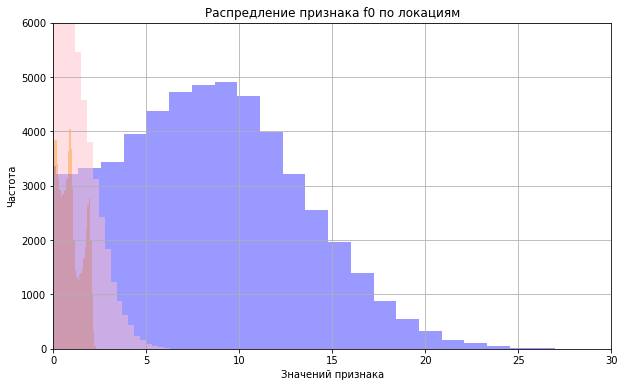

In [13]:
#объединим два графика на одном поле
axes = geo_1['f0'].plot(
    kind='hist',
    grid=True,
    figsize=(10, 6),
    alpha=0.7,
    ylim=(0, 6000),
    xlim=(0, 30),
    bins = 50,
    color = 'orange',
)

ax_1 = geo_2['f0'].plot(
    kind='hist',
    grid=True,
    figsize=(10, 6),
    alpha=0.4,
    ylim=(0, 6000),
    xlim=(0, 30),
    bins = 50,
    color = 'blue',
    ax = axes
)

geo_3['f0'].plot(
    kind='hist',
    grid=True,
    figsize=(10, 6),
    alpha=0.5,
    ylim=(0, 6000),
    xlim=(0, 30),
    bins = 50,
    color = 'pink',
    ax = ax_1
)

plt.title('Распредление признака f0 по локациям')
plt.xlabel('Значений признака')
plt.ylabel('Частота');

Напишем фукнцию, которая будет обрабатывать таблицы по 1му способу:

In [14]:
def norm_well_situation_part_1(table, all_id):
    for well in list(all_id[all_id.duplicated()]):
        cool_table = table[table['id'] == well]
        #суммируем строки таблицы и заменяем на сумму если дубликаты в самой таблице
        if cool_table.shape[0] == 2:
            operation_id = cool_table.head(1)['id'].unique()[0]
            operation_f0 = cool_table.head(1)['f0'].unique()[0] + cool_table.tail(1)['f0'].unique()[0]
            operation_f1 = cool_table.head(1)['f1'].unique()[0] + cool_table.tail(1)['f1'].unique()[0]
            operation_f2 = cool_table.head(1)['f2'].unique()[0] + cool_table.tail(1)['f2'].unique()[0]
            operation_product = cool_table.head(1)['product'].unique()[0] + cool_table.tail(1)['product'].unique()[0]
            new_cool = {'id':operation_id,
                        'f0':operation_f0,
                        'f1': operation_f1,
                        'f2': operation_f2, 
                        'product' : operation_product}
            #заменяем дубликаты на просуммированную строчку 
            table = table.append(new_cool, ignore_index=True)
    table.drop_duplicates(subset = ['id'], keep='last', inplace=True)
    return table

Проверим работу функции на простых датафреймах:

In [15]:
df = {
    'id' : ['1', '2', '3', '1'],
    'f0' : [1, 2, 3, 4],
    'f1' : [1, 2, 3, 4],
    'f2' : [1, 2, 3, 4],
    'product' : [2, 10, 1, 5]
}
df_1 = {
    'id' : ['3', '4', '5', '6'],
    'f0' : [1, 2, 3, 4],
    'f1' : [1, 2, 3, 4],
    'f2' : [1, 2, 3, 4],
    'product' : [2, 10, 1, 5]
}
df_2 = {
    'id' : ['6', '7', '7', '8'],
    'f0' : [1, 2, 3, 4],
    'f1' : [1, 2, 3, 4],
    'f2' : [1, 2, 3, 4],
    'product' : [2, 10, 1, 5]
}
geo = pd.DataFrame(df)
geoo = pd.DataFrame(df_1)
geeoo = pd.DataFrame(df_2)

In [16]:
geo #датафрейм с дубликатами по id

,id,f0,f1,f2,product
0,1,1,1,1,2
1,2,2,2,2,10
2,3,3,3,3,1
3,1,4,4,4,5


In [17]:
geoo  #датафрейм без дубликатов по id

,id,f0,f1,f2,product
0,3,1,1,1,2
1,4,2,2,2,10
2,5,3,3,3,1
3,6,4,4,4,5


In [18]:
all_id_0  = pd.concat([geo['id'], geoo['id'], geeoo['id']]).reset_index(drop=True)
print(f'Кол-во одинаковых скважин по всем локациям:', all_id_0.duplicated().sum())

Кол-во одинаковых скважин по всем локациям: 4


In [19]:
geo = norm_well_situation_part_1(geo, all_id_0)

In [20]:
geo

,id,f0,f1,f2,product
1,2,2,2,2,10
2,3,3,3,3,1
4,1,5,5,5,7


In [21]:
geoo = norm_well_situation_part_1(geoo, all_id_0)

In [22]:
geoo

,id,f0,f1,f2,product
0,3,1,1,1,2
1,4,2,2,2,10
2,5,3,3,3,1
3,6,4,4,4,5


Все работает! Теперь обработаем исходные датафреймы:

In [23]:
geo_1 = norm_well_situation_part_1(geo_1, all_id)
geo_2 = norm_well_situation_part_1(geo_2, all_id)
geo_3 = norm_well_situation_part_1(geo_3, all_id)

Проверим уменьшилось ли количество дубликатов:

In [24]:
all_id  = pd.concat([geo_1['id'], geo_2['id'], geo_3['id']]).reset_index(drop=True)
print(f'Кол-во одинаковых скважин по всем локациям:', all_id.duplicated().sum())

Кол-во одинаковых скважин по всем локациям: 31


Удалим оставшиеся дубликаты:

In [25]:
geo_1 = geo_1.set_index('id')
geo_2 = geo_2.set_index('id')
geo_3 = geo_3.set_index('id')
for well in all_id[all_id.duplicated()].unique():
    if well in geo_1.index:
        geo_1.drop([well],axis = 0, inplace = True)
    if well in geo_2.index:
        geo_2.drop([well],axis = 0, inplace = True)
    if well in geo_3.index:
        geo_3.drop([well],axis = 0, inplace = True)

In [26]:
geo_1 = geo_1.reset_index()
geo_2 = geo_2.reset_index()
geo_3 = geo_3.reset_index()

In [27]:
all_id  = pd.concat([geo_1['id'], geo_2['id'], geo_3['id']]).reset_index(drop=True)
print(f'Кол-во одинаковых скважин по всем локациям:', all_id.duplicated().sum())

Кол-во одинаковых скважин по всем локациям: 0


#### Разделение на выборки

Разделим данные на обучающую и тетсовую выборки:

`y` - за нее возьмем столбец product

`X` - все кроме столбца product, id

In [28]:
geo_1

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
...,...,...,...,...,...
99958,AGS9W,0.520952,-0.363457,-2.972517,145.600958
99959,Tdehs,0.941485,0.729104,3.169430,156.999326
99960,fiKDv,0.207224,1.869671,11.980199,233.164476
99961,TtcGQ,0.679987,0.917812,7.351596,186.668194


In [29]:
X_geo_1 = geo_1.drop(["product","id"], axis=1)
y_geo_1 = geo_1["product"]

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    X_geo_1, y_geo_1, 
    test_size=0.2, 
    random_state=42
)

In [31]:
X_train

,f0,f1,f2
12604,-0.062226,0.375773,3.557455
89997,0.726233,0.798363,2.141410
99172,-0.029711,0.231071,4.258408
89794,0.464464,0.723572,7.202757
36423,0.134606,0.224370,-6.047276
...,...,...,...
6265,0.035706,1.021447,-0.014376
54886,-0.556188,0.772744,0.844034
76820,0.243252,-0.093290,1.161646
860,0.652792,-0.484070,7.155391


#### Стандартизация данных

Т.к все признаки различны, ипсользуем стандартизацию, чтобы привести все к одному масштабу:

In [32]:
numeric_data = list(X_geo_1.select_dtypes([np.number]).columns)

In [33]:
pd.options.mode.chained_assignment = None
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train[numeric_data] = scaler.transform(X_train[numeric_data])
X_test[numeric_data] = scaler.transform(X_test[numeric_data])

In [34]:
X_train.head()

,f0,f1,f2
12604,0.357041,0.450346,0.523897
89997,0.566130,0.605831,0.469730
99172,0.365664,0.397106,0.550711
89794,0.496712,0.578313,0.663339
36423,0.409238,0.394640,0.156493


### Локация №2

#### Пропуски, дубликаты

In [35]:
geo_2.isna().mean() * 100

id         0.0
f0         0.0
f1         0.0
f2         0.0
product    0.0
dtype: float64

Пропусков не обнаружилось! Посмотрим на дубликаты:

In [36]:
geo_2.duplicated().sum() == 0

True

Неявные дубликаты мы обработали еще в разделе по "Локации №1". Перейдем к разделению на выборки:

#### Разделение на выборки

Разделим данные на обучающую и тетсовую выборки:

`y` - за нее возьмем столбец product

`X` - все кроме столбца product, id

In [37]:
X_geo_2 = geo_2.drop(["product","id"], axis=1)
y_geo_2 = geo_2["product"]

In [38]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
    X_geo_2, y_geo_2, 
    test_size=0.2, 
    random_state=42
)

In [39]:
X_train_2

,f0,f1,f2
48052,7.934434,0.889582,-0.001522
38234,12.037407,1.771411,2.006788
3806,0.465546,-6.955174,4.997481
63136,8.307240,-2.018355,1.002945
6006,-10.630533,-2.615793,0.003582
...,...,...,...
6265,-3.813139,-4.677472,0.996837
54886,3.670295,-11.878941,4.001246
76820,-3.308695,2.557770,2.999423
860,-2.206408,-6.205406,0.008217


#### Стандартизация данных

In [40]:
pd.options.mode.chained_assignment = None
scaler = MinMaxScaler()
scaler.fit(X_train_2)
X_train_2[numeric_data] = scaler.transform(X_train_2[numeric_data])
X_test_2[numeric_data] = scaler.transform(X_test_2[numeric_data])

In [41]:
X_train_2

,f0,f1,f2
48052,0.647930,0.632270,0.002368
38234,0.715157,0.652732,0.288481
3806,0.525552,0.450239,0.714548
63136,0.654038,0.564794,0.145469
6006,0.343742,0.550931,0.003095
...,...,...,...
6265,0.455445,0.503091,0.144599
54886,0.578062,0.335988,0.572620
76820,0.463711,0.670979,0.429896
860,0.481772,0.467637,0.003756


### Локация №3

#### Пропуски, дубликаты

In [42]:
geo_3.isna().mean() * 100

id         0.0
f0         0.0
f1         0.0
f2         0.0
product    0.0
dtype: float64

Пропусков не обнаружилось! Посмотрим на дубликаты:

In [43]:
geo_3.duplicated().sum() == 0

True

Неявные дубликаты мы обработали еще в разделе по "Локации №1". Перейдем к разделению на выборки:

#### Разделение на выборки

Разделим данные на обучающую и тетсовую выборки:

`y` - за нее возьмем столбец product

`X` - все кроме столбца product, id

In [44]:
X_geo_3 = geo_3.drop(["product","id"], axis=1)
y_geo_3 = geo_3["product"]

In [45]:
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(
    X_geo_3, y_geo_3, 
    test_size=0.2, 
    random_state=42
)

In [46]:
X_train_3

,f0,f1,f2
8138,4.158744,1.398708,4.340214
2007,0.123968,-0.100828,1.205108
89828,-4.212940,-1.646886,1.772746
88245,-1.805386,0.323563,3.183120
76287,1.705896,1.451559,1.434843
...,...,...,...
6265,-1.842672,-0.003145,0.926830
54886,0.164229,-1.126222,3.552921
76820,0.960789,-0.681623,4.791471
860,-1.446403,-2.164471,3.334692


#### Стандартизация данных

In [47]:
pd.options.mode.chained_assignment = None
scaler = MinMaxScaler()
scaler.fit(X_train_3)
X_train_3[numeric_data] = scaler.transform(X_train_3[numeric_data])
X_test_3[numeric_data] = scaler.transform(X_test_3[numeric_data])

In [48]:
X_train_3

,f0,f1,f2
8138,0.807509,0.568212,0.562656
2007,0.555308,0.467766,0.452074
89828,0.284222,0.364204,0.472096
88245,0.434711,0.496193,0.521843
76287,0.654190,0.571752,0.460177
...,...,...,...
6265,0.432380,0.474309,0.442259
54886,0.557825,0.399080,0.534886
76820,0.607615,0.428862,0.578572
860,0.457150,0.329534,0.527189


## Обучение и проверка модели

Предобработав данные по регионам, перейдем к обучению моделей. 

In [49]:
kf = KFold(n_splits=5, shuffle=True)

Напишем функции по обучению регрессий и сравним результаты по тесту, чтобы выбрать наилучшую модель для локации. 

In [50]:
def simple_linear_regression(X_train, y_train, X_test, y_test):
    #обучаем модель
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    #находим значения кросс-валидации
    cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring="neg_root_mean_squared_error")
    means = np.mean(-cv_scores)
    print("---------")
    print("Cross validation scores:\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
    print("Mean CV RMSE = %.4f" % means)
    print("-----------------------")
    #тестируем модель
    y_pred = model.predict(X_test)
    eror = mean_squared_error(y_test, y_pred, squared=False)
    print("---------")
    print("Test RMSE = %.4f" % eror)
    print("-----------------------")
    
    return (round(eror, 3), round(means, 4), model)

In [51]:
def simple_sgd(X_train, y_train, X_test, y_test):
    #обучаем модель
    model = SGDRegressor(random_state = 42)
    model.fit(X_train, y_train)
    
    #находим значения кросс-валидации
    cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring="neg_root_mean_squared_error")
    means = np.mean(-cv_scores)
    print("---------")
    print("Cross validation scores:\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
    print("Mean CV RMSE = %.4f" % means)
    print("-----------------------")
    
    #оптимизация модели 
    param_grid = {
        'alpha': [0.001],
        'learning_rate': ['constant', 'optimal']}
    searcher = GridSearchCV(model, param_grid, cv=kf)
    searcher.fit(X_train, y_train)
    best_= searcher.best_estimator_
    
    #тестируем модель, используя pipline 
    simple_pipeline = Pipeline([('regression', best_)])

    model = simple_pipeline.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    eror = mean_squared_error(y_test, y_pred, squared=False)
    print("---------")
    print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))
    print("-----------------------")
    
    return (round(eror, 3), round(means, 4), model)

Напишем фукнцию, которая отобразит нам финальную таблицу, по которой будем делать выводы:

In [52]:
def final_table(rmse_1, mean_1, rmse_2, mean_2):
    rmses = []
    means = []
    rmses.append([rmse_1, rmse_2])
    means.append([mean_1, mean_2])
    df = {
        'rmse' : rmses[0],
        'means' : means[0]
    }
    df = pd.DataFrame(df, index = ['Linear Regression', 'SGD'])
    return df

### Локация №1

In [53]:
rmse_reg_1, mean_reg_1, model_reg_1 = simple_linear_regression(X_train, y_train, X_test, y_test)

---------
Cross validation scores:
	 -37.7661
	-37.3328
	-37.8216
	-37.7407
	-37.8384
Mean CV RMSE = 37.6999
-----------------------
---------
Test RMSE = 37.7188
-----------------------


In [54]:
rmse_reg_1_sgd, mean_reg_1_sgd, model_reg_1_sgd = simple_sgd(X_train, y_train, X_test, y_test)

---------
Cross validation scores:
	 -37.6948
	-37.7745
	-37.4961
	-37.8476
	-37.6993
Mean CV RMSE = 37.7025
-----------------------
---------
Test RMSE = 37.7420
-----------------------


In [55]:
final_table(rmse_reg_1, mean_reg_1, rmse_reg_1_sgd, mean_reg_1_sgd)

,rmse,means
Linear Regression,37.719,37.6999
SGD,37.742,37.7025


В данном случае минимальный rmse именно у линейной регрессии!

### Локация №2

In [56]:
rmse_reg_2, mean_reg_2, model_reg_2 = simple_linear_regression(X_train_2, y_train_2, X_test_2, y_test_2)

---------
Cross validation scores:
	 -0.8916
	-0.8936
	-0.8907
	-0.8903
	-0.8917
Mean CV RMSE = 0.8916
-----------------------
---------
Test RMSE = 0.8864
-----------------------


In [57]:
rmse_reg_2_sgd, mean_reg_2_sgd, model_reg_2_sgd = simple_sgd(X_train_2, y_train_2, X_test_2, y_test_2)

---------
Cross validation scores:
	 -0.8959
	-0.8972
	-0.8952
	-0.8918
	-0.8961
Mean CV RMSE = 0.8952
-----------------------
---------
Test RMSE = 1.1707
-----------------------


In [58]:
final_table(rmse_reg_2, mean_reg_2, rmse_reg_2_sgd, mean_reg_2_sgd)

,rmse,means
Linear Regression,0.886,0.8916
SGD,1.171,0.8952


В данном случае минимальный rmse именно у линейной регрессии!

### Локация №3

In [59]:
rmse_reg_3, mean_reg_3, model_reg_3 = simple_linear_regression(X_train_3, y_train_3, X_test_3, y_test_3)

---------
Cross validation scores:
	 -40.1056
	-39.7452
	-40.0691
	-40.0724
	-40.0874
Mean CV RMSE = 40.0159
-----------------------
---------
Test RMSE = 40.2482
-----------------------


In [60]:
rmse_reg_3_sgd, mean_reg_3_sgd, model_reg_3_sgd = simple_sgd(X_train_3, y_train_3, X_test_3, y_test_3)

---------
Cross validation scores:
	 -40.2224
	-40.1985
	-40.0164
	-39.7325
	-39.9194
Mean CV RMSE = 40.0178
-----------------------
---------
Test RMSE = 40.2706
-----------------------


In [61]:
final_table(rmse_reg_3, mean_reg_3, rmse_reg_3_sgd, mean_reg_3_sgd)

,rmse,means
Linear Regression,40.248,40.0159
SGD,40.271,40.0178


В данном случае минимальный rmse именно у линейной регрессии!

## Подготовка к расчёту прибыли

**Известно:**

* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.

* Бюджет на разработку скважин в регионе — 10 млрд рублей.

* При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

In [62]:
budget = 10**10
income_per_barrel = 450 * 10**3 
count_200 = 200 
count_500 = 500

In [63]:
loss_threshold = budget/(income_per_barrel*count_200)

In [72]:
print('Минимальная средняя продуктивность скважины (в тыс. баррелей) для достижения порога окупаемости:', np.ceil(loss_threshold))

Минимальная средняя продуктивность скважины (в тыс. баррелей) для достижения порога окупаемости: 112.0


## Расчёт прибыли и рисков 

In [65]:
def predicts(model, X_test):
    predictions = pd.Series(model.predict(X_test))
    return predictions

In [99]:
state = np.random.RandomState(12345)
def region_profit(target, predictions):
    values = [] 
    wells = []
    for i in range(1000):
        target_subsample = target.reset_index(drop=True).sample(500, replace=False, random_state=state)
        probs_subsample = predictions[target_subsample.index]
        best_pred = pd.Series(probs_subsample).sort_values(ascending=False)[:200]
        best_target = target_subsample[best_pred.index]
        revenues = income_per_barrel * best_target.sum() - budget
        for_well = best_target.sum() / count_200
        values.append(revenues)
        wells.append(for_well)
 
    values = pd.Series(values)
    mean = values.mean()
    mean_well_product = for_well.mean()
    lower = values.quantile(.025)
    upper = values.quantile(.975)
    loss_probability = (values<0).mean()
    return ((round(lower, 3), round(upper, 3)), round(mean), loss_probability, round(mean_well_product))

In [97]:
predictions = predicts(model_reg_1, X_test)
predictions_2 = predicts(model_reg_2, X_test_2)
predictions_3 = predicts(model_reg_3, X_test_3)

In [100]:
i = 1
for target, prediction in zip([y_test, y_test_2, y_test_3],
                              [predictions, predictions_2, predictions_3]):
    interval, mean_revenue, risk, mean_well = region_profit(target, prediction)
    print(f"Region {i}:")
    print("\n-----------------------------------------")
    print(f"Mean: {mean_revenue}")
    print(f"Mean product for one well: {mean_well}")
    print(f"If loss threshold was passed: {mean_well >= loss_threshold}")
    print(f"95% confidence interval: {interval}")
    print(f"Risk of loss: {risk}")
    print("-----------------------------------------\n\n")
    i+=1

Region 1:

-----------------------------------------
Mean: 426988155
Mean product for one well: 118
If loss threshold was passed: True
95% confidence interval: (-56362564.111, 909045501.862)
Risk of loss: 0.046
-----------------------------------------


Region 2:

-----------------------------------------
Mean: 469201179
Mean product for one well: 115
If loss threshold was passed: True
95% confidence interval: (66643361.352, 856581242.353)
Risk of loss: 0.01
-----------------------------------------


Region 3:

-----------------------------------------
Mean: 339696239
Mean product for one well: 117
If loss threshold was passed: True
95% confidence interval: (-181934590.273, 856486354.433)
Risk of loss: 0.111
-----------------------------------------




## Вывод

**Обзор данных**

- Данные о скважинах получили из трех файлов по локациям `/datasets/geo_1.csv`, `/datasets/geo_2.csv`, `/datasets/geo_3.csv`.
- Предварительно качество данных было относительно хорошим: была лишь малая доля дубликатов.
- Сами данные представляли из себя сводку информации о скважинах (признаки, объем нефти, id).

**Предобработка**

- Проверили данные на дубликаты - нашли одинаковые id по локациям, которые впоследствии удалили.
- Сделали стандартизацию данных через масштабирование min-max. 
- Разделели выборки по локациям

**Исследование моделей**
 
Регион 1:

Лучшая модель - линейная регрессия с ошибкой в 37.7

Регион 2:

Лучшая модель - линейная регрессия с ошибкой в 0.88

Регион 3:

Лучшая модель - линейная регрессия с ошибкой в 40.24

**Выбор региона для разработки месторождения**

Лучшим регионом для дальнейшей работы с месторождениями лучше всего выбрать **локацию №2**, потому что средняя прибыль здесь наибольшая, риск убытков наименьший, а минимальный порог окупаемости достигнут.